# Dissertation II - Code

<hr style="border:1px solid black"> </hr>

## Import Libraries

In [1]:
# Avoid Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Data managing
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from ydata_synthetic.synthesizers.regular import WGAN_GP 

## Data visualisations
import seaborn as sns
import matplotlib.pyplot as plt


## Modelling 

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# xgboost
from xgboost.sklearn import XGBClassifier

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


## Scoring
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

## Tuning
from sklearn.model_selection import GridSearchCV

In [ ]:
# Dataframe Printing Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

<hr style="border:1px solid black"> </hr>

## Helper Functions

In [3]:
#Adapted from: https://www.kaggle.com/kucherevskiy/rul-prediction
def prepare_data(data):
    df = data.copy()
    tempMax = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    tempMax = pd.DataFrame(tempMax)
    tempMax.columns = ['unit_number','max']
    df = df.merge(tempMax, on=['unit_number'], how='left')
    df['label'] = np.where(df['max'] - df['time_in_cycles'] <= 15, 1, 0 )
    df.drop(columns=['max'],inplace = True)
    
    return df

In [4]:
# Source:
# Function to retrieve outliers
def find_outliers(dataset):
    
    outliers = {}
    
    for i in list(dataset.loc[:, dataset.dtypes != np.object]):
        Q1 = dataset[i].quantile(0.25)
        Q3 = dataset[i].quantile(0.75)
        IQR = Q3 - Q1
        num_outliers = ((dataset[i] < (Q1 - 1.5 * IQR)) | (dataset[i] > (Q3 + 1.5 * IQR)))
        outliers[i] = num_outliers
        
    return outliers

In [5]:
# Source:
# Testing for outliers
def plot_box(dataset, cols=3, width=20, height=20, hspace=0.7, wspace=0.5):
    
    outliers = find_outliers(dataset)
    
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(outliers.keys()):
        ax = fig.add_subplot(rows, cols, i + 1)
        g = sns.boxplot(dataset[column])
        ax.set_title('Box plot of {}. Outliers: {}'.format(column, outliers[column].sum()))

In [6]:
#Plot distributions of each feature (Adapted from: Daniel Martinez)
def plot_distribution(dataset, cols=4, width=20, height=15, hspace=0.7, wspace=0.7):
    
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        g = sns.distplot(dataset[column])
        plt.xticks(rotation=25)

In [7]:
# Plot class distribution
def class_distribution(data):
    plt.bar(data['label'].unique(), data['label'].value_counts(), color=['green', 'red'])
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0,1], ['Healthy (0)', 'Risk of Failure (1)'])
    plt.show()

<hr style="border:1px solid black"> </hr>

## Importing Data and Initial Cleaning

In [8]:
# Column Names
columns = ['unit_number','time_in_cycles','Altitude','Mach','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [9]:
# Train
df1 = pd.read_csv('/Users/nicolasrosal/Desktop/Dissertation2/CMAPSSData/train_FD003.txt',
                  sep=" ",
                  header=None)

# Test
df2 = pd.read_csv('/Users/nicolasrosal/Desktop/Dissertation2/CMAPSSData/test_FD003.txt',
                  sep=" ",
                  header=None)

- Dataframe1:

In [10]:
# Dropping empty columns
df1.drop(columns=[26,27], inplace=True)

In [11]:
#Renaming Columns
df1.columns = columns

In [12]:
# Adding RUL column
df1 = prepare_data(df1)

- Dataframe2:

In [13]:
# Dropping empty columns
df2.drop(columns=[26,27], inplace=True)

In [14]:
#Renaming Columns
df2.columns = columns

In [15]:
# Adding RUL column
df2 = prepare_data(df2)

### Combining df1 and df2

###### Creating a dataframe for Exploratory Data Analysis and Modelling

In [16]:
TTF_data = pd.concat([df1, df2])

<hr style="border:1px solid black"> </hr>

## Exploratory Data Analysis

- Missing Values:

In [17]:
print('Number of missing values:', TTF_data.isna().sum().sum())

Number of missing values: 0


- Descriptive Statistics:

In [18]:
TTF_data.describe()

,unit_number,time_in_cycles,Altitude,Mach,TRA,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,label
count,41316.000000,41316.000000,41316.000000,41316.000000,41316.0,4.131600e+04,41316.000000,41316.000000,41316.000000,4.131600e+04,...,41316.000000,41316.000000,41316.000000,4.131600e+04,41316.000000,41316.0,41316.0,41316.000000,41316.000000,41316.000000
mean,49.939563,125.790323,-0.000021,0.000001,100.0,5.186700e+02,642.381587,1587.086657,1402.903329,1.462000e+01,...,2388.051306,8141.842465,8.395718,3.000000e-02,392.298819,2388.0,100.0,38.991901,23.395388,0.077452
std,29.595390,94.313702,0.002197,0.000294,0.0,3.344707e-10,0.492753,6.445107,9.019166,4.025273e-12,...,0.156796,14.533754,0.053640,2.142756e-14,1.655365,0.0,0.0,0.222143,0.133404,0.267310
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,...,2386.930000,8099.680000,8.156300,3.000000e-02,387.000000,2388.0,100.0,38.170000,22.872600,0.000000
25%,24.000000,52.000000,-0.001500,-0.000300,100.0,5.186700e+02,642.030000,1582.580000,1396.360000,1.462000e+01,...,2387.990000,8133.500000,8.364700,3.000000e-02,391.000000,2388.0,100.0,38.850000,23.310000,0.000000
50%,49.000000,108.000000,0.000000,0.000000,100.0,5.186700e+02,642.330000,1586.610000,1401.475000,1.462000e+01,...,2388.050000,8139.550000,8.396800,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.394900,0.000000
75%,76.000000,176.000000,0.001500,0.000300,100.0,5.186700e+02,642.690000,1591.060000,1408.190000,1.462000e+01,...,2388.120000,8146.600000,8.431200,3.000000e-02,393.000000,2388.0,100.0,39.130000,23.474900,0.000000
max,100.000000,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,...,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500,1.000000


In [19]:
# Drop columns with constant values (std < 0.00001) and time_in_cycles (not a time series analysis)
TTF_data.drop(columns=['time_in_cycles', 'TRA', 'Mach','T2', 'P2', 'farB', 'Nf_dmd', 'PCNfR_dmd'], inplace=True)

- Correlation Analysis:

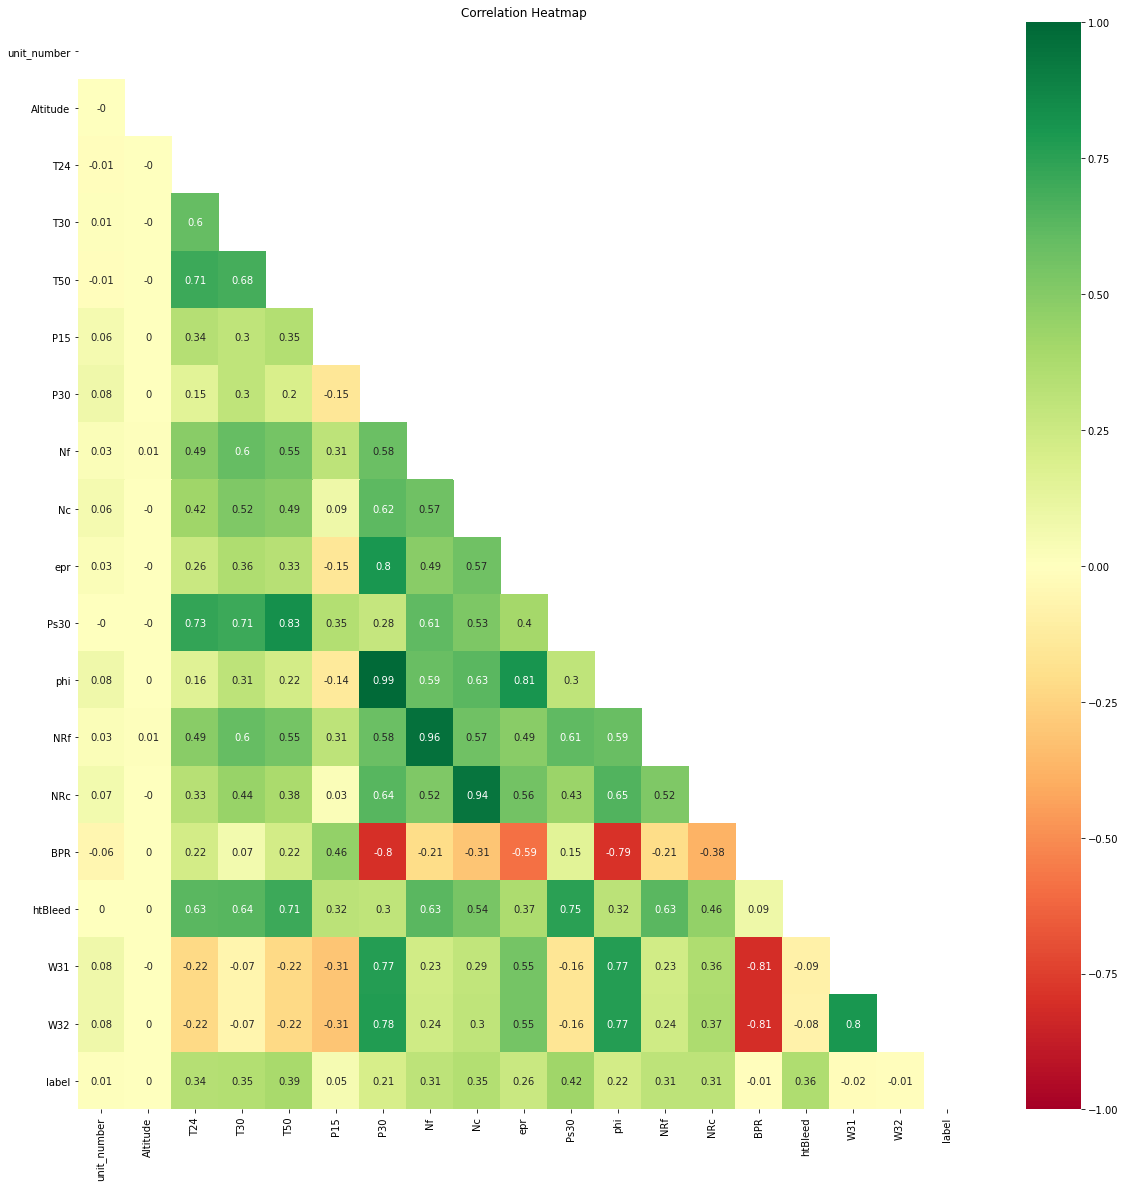

In [20]:
#Source: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(20, 20))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(TTF_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(np.round(TTF_data.corr(), 2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Correlation Heatmap');

In [21]:
# Drop highly correlated variables and uncorrelated variables
TTF_data.drop(columns=['unit_number', 'Altitude', 'phi', 'NRf', 'NRc'], inplace=True)

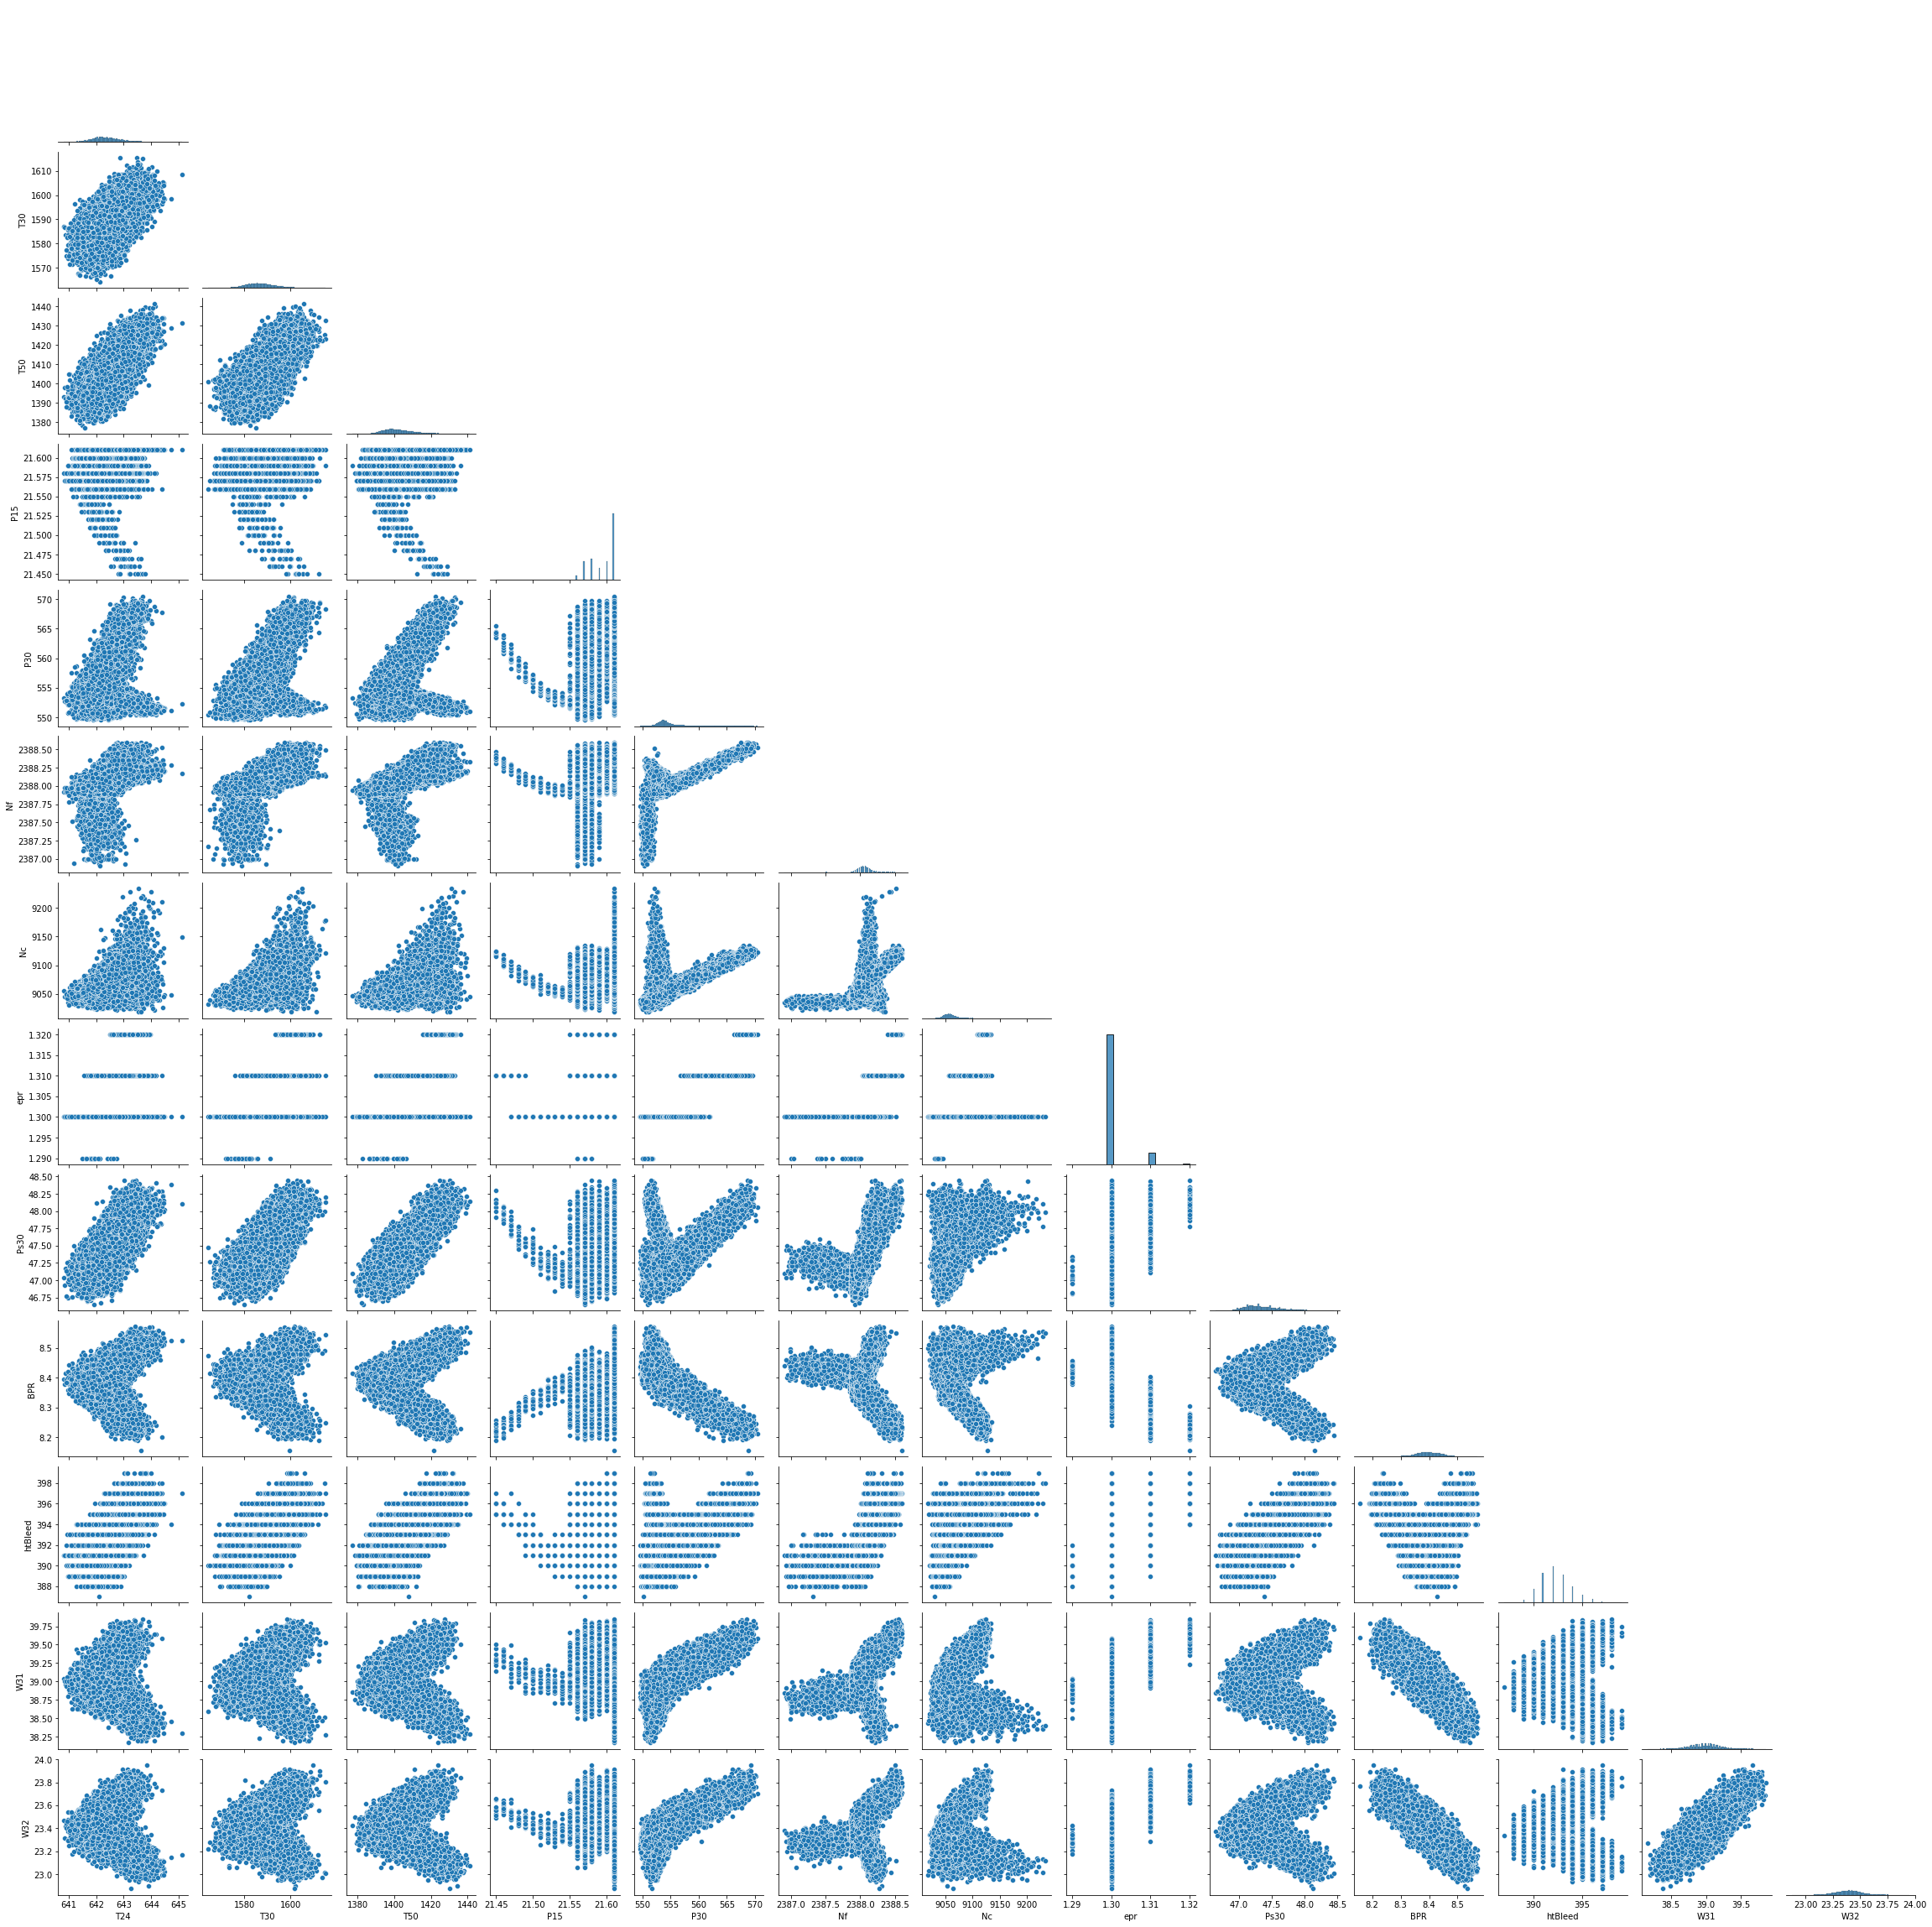

In [22]:
# Visualizing distribution and correlation of remaining variables 
sns.pairplot(TTF_data.drop(columns=['label']), corner=True)

- Outlier Analysis:

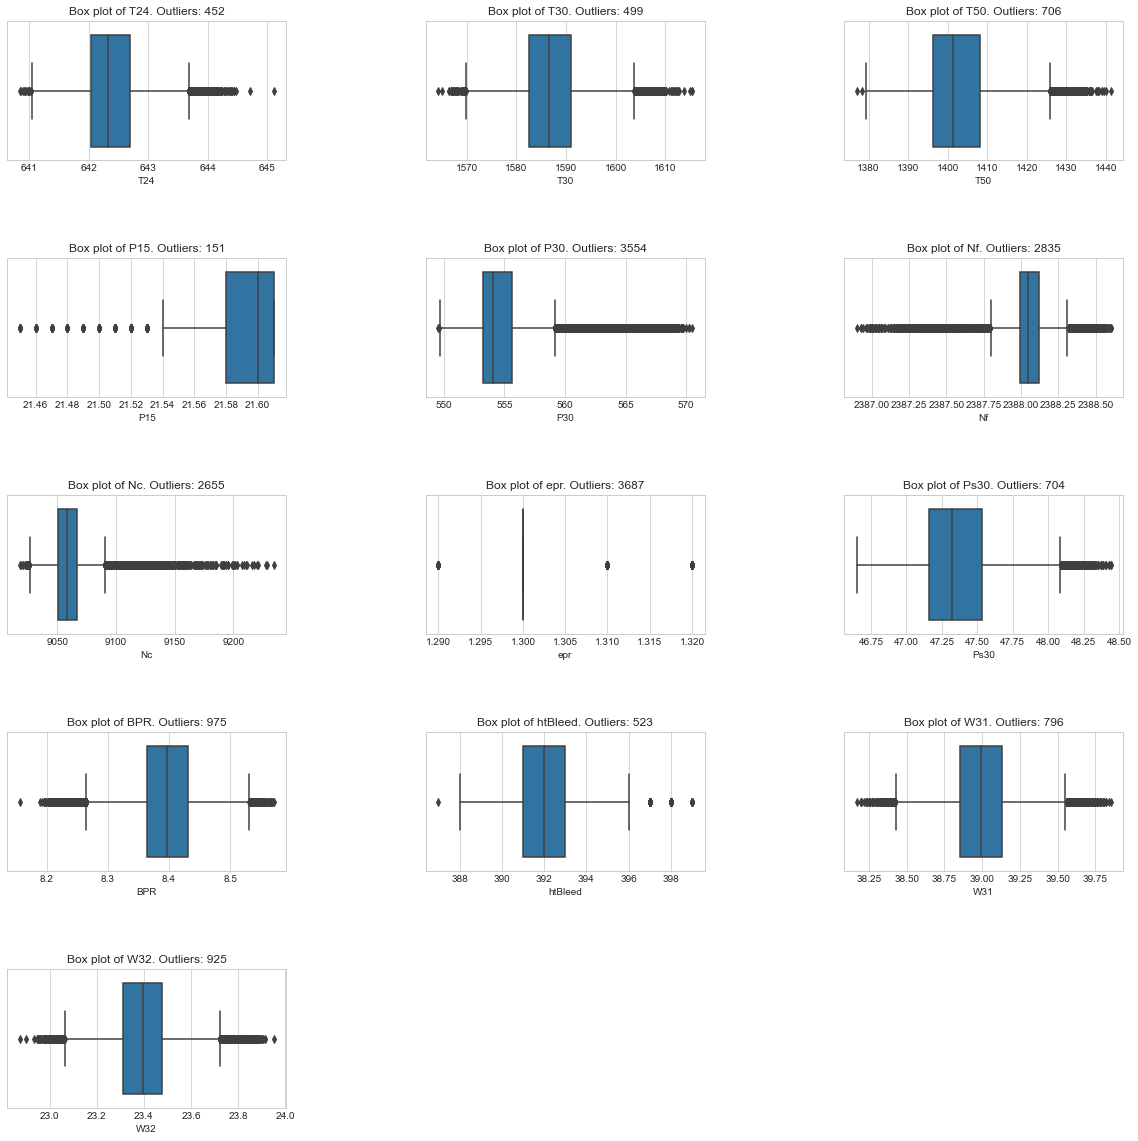

In [23]:
plot_box(TTF_data.drop(columns=['label']))

- Class Distribution:

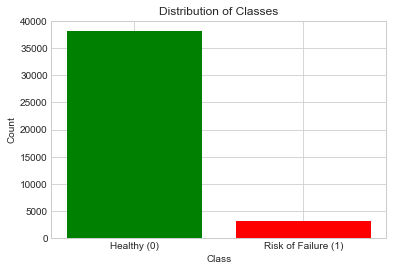

In [24]:
class_distribution(TTF_data)

<hr style="border:1px solid black"> </hr>

## Feature Engineering

In [25]:
# Splitting the data into X (parameters) and y (label)
X = TTF_data.drop(columns=['label']).values
y = TTF_data['label'].values

In [26]:
# Scaling Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Creating TFF_scaled
TFF_scaled = pd.DataFrame(X_scaled)
TFF_scaled['label'] = y
TFF_scaled.columns = ['T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'epr',
                      'Ps30', 'BPR', 'htBleed', 'W31', 'W32', 'label']

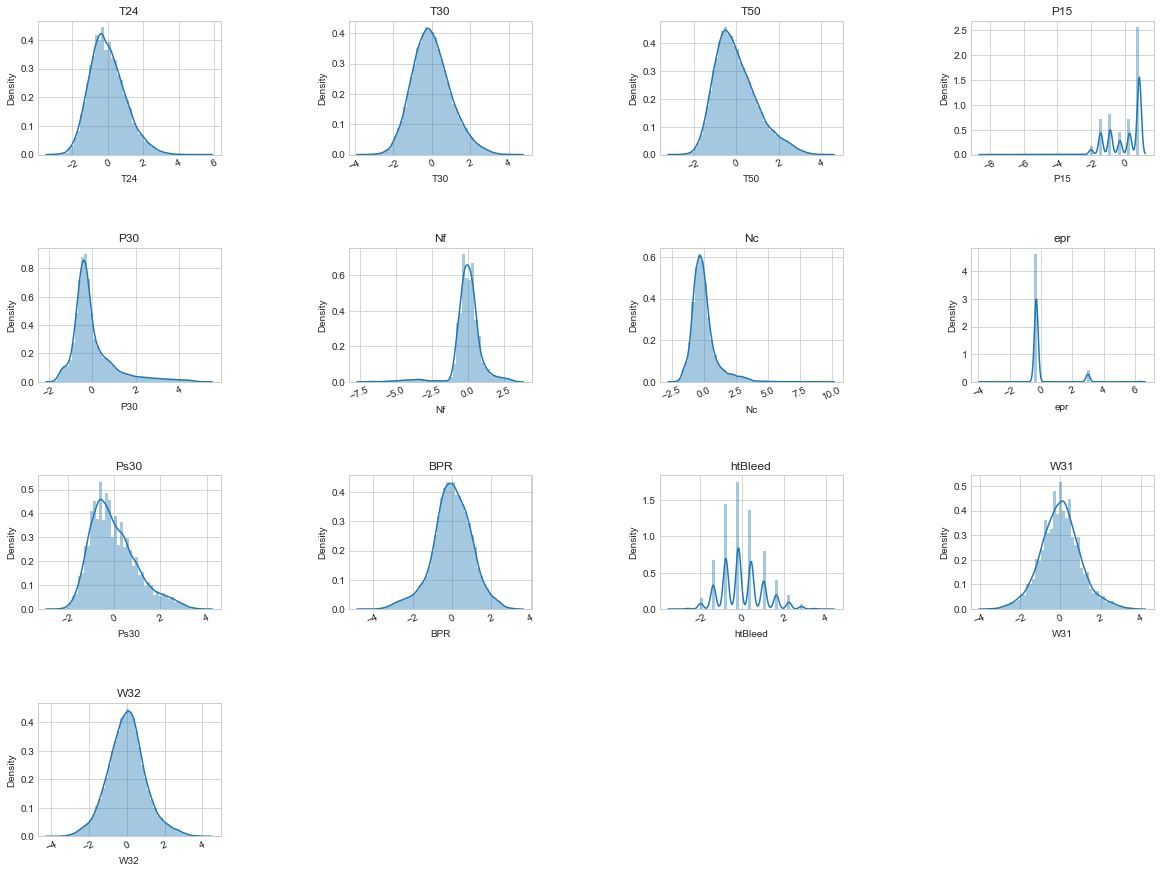

In [28]:
# Visualising distributions
plot_distribution(TFF_scaled.drop(columns=['label']))

### Data Imbalance

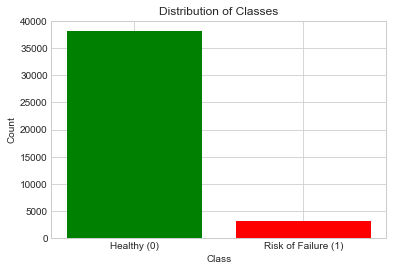

In [29]:
# Display class counts
class_distribution(TFF_scaled)

In [30]:
# Splitting intro train and test data
X_train, X_test, y_train, y_test = train_test_split(TFF_scaled.drop(columns=['label']), 
                                                    TFF_scaled['label'], 
                                                    test_size=0.2, 
                                                    random_state=123)

### No Data Imbalance

In [31]:
failure = TFF_scaled[TFF_scaled.label == 1]
healthy = TFF_scaled[TFF_scaled.label == 0]

- Upsampling:

In [32]:
# Upsample minority class
failure_upsampled = resample(failure,
                             n_samples=healthy.shape[0],
                             random_state=123)
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([healthy, failure_upsampled])

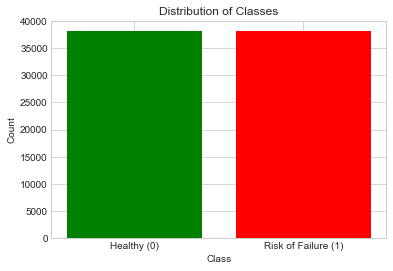

In [33]:
# Display new class counts - upsampled data
class_distribution(data_upsampled)

In [34]:
# Splitting intro train and test data
Xbal_train, Xbal_test, ybal_train, ybal_test = train_test_split(data_upsampled.drop(columns=['label']), 
                                                                data_upsampled['label'], 
                                                                test_size=0.2, 
                                                                random_state=123)

- Synthetic Data:

Adapted from - https://github.com/ydataai/ydata-synthetic/blob/master/examples/regular/wgan_example.py

In [35]:
# Define model, data columns and label column
model = WGAN_GP
data_cols = list(failure.columns[failure.columns != 'label'])
label_cols = ['label']

In [36]:
#Defining training data for GAN
train_data = failure.copy().reset_index(drop=True)

In [37]:
#Define the GAN and training parameters
noise_dim = 32
dim = 64
batch_size = 64

log_step = 100
epochs = 500
learning_rate = 1e-3
beta_1 = 0.5
beta_2 = 0.5
models_dir = './cache'

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_data[data_cols].shape[1], dim]
train_args = ['', epochs, log_step]

In [38]:
#Training the WGAN_GP model
synthesizer = model(gan_args, n_critic=1)
synthesizer.train(train_data[data_cols], train_args)

  0%|          | 1/500 [00:02<21:38,  2.60s/it]

Iteration: 0 | disc_loss: 3.218850612640381 | gen_loss: 0.005387743003666401
Iteration: 1 | disc_loss: 0.29320472478866577 | gen_loss: -0.010990495793521404
Iteration: 2 | disc_loss: 0.06333890557289124 | gen_loss: -0.028626292943954468
Iteration: 3 | disc_loss: -0.10384020209312439 | gen_loss: -0.04438568651676178
Iteration: 4 | disc_loss: -0.19891364872455597 | gen_loss: -0.044713012874126434
Iteration: 5 | disc_loss: -0.21615326404571533 | gen_loss: -0.03770219534635544
Iteration: 6 | disc_loss: -0.23703555762767792 | gen_loss: -0.028770167380571365
Iteration: 7 | disc_loss: -0.282520055770874 | gen_loss: -0.012105805799365044
Iteration: 8 | disc_loss: -0.28961682319641113 | gen_loss: 0.005223349202424288
Iteration: 9 | disc_loss: -0.37294623255729675 | gen_loss: 0.026227284222841263
Iteration: 10 | disc_loss: -0.24024561047554016 | gen_loss: 0.04469515383243561


  4%|▍         | 19/500 [00:02<10:16,  1.28s/it]

Iteration: 11 | disc_loss: -0.46022915840148926 | gen_loss: 0.07428446412086487
Iteration: 12 | disc_loss: -0.47657662630081177 | gen_loss: 0.10573117434978485
Iteration: 13 | disc_loss: -0.5275673270225525 | gen_loss: 0.1149861067533493
Iteration: 14 | disc_loss: -0.40657567977905273 | gen_loss: 0.09113918244838715
Iteration: 15 | disc_loss: -0.46247950196266174 | gen_loss: 0.07674124836921692
Iteration: 16 | disc_loss: -0.3972189426422119 | gen_loss: 0.060819655656814575
Iteration: 17 | disc_loss: -0.44655337929725647 | gen_loss: 0.030103005468845367
Iteration: 18 | disc_loss: -0.430564820766449 | gen_loss: 0.006728977896273136
Iteration: 19 | disc_loss: -0.31173449754714966 | gen_loss: 0.00951140746474266
Iteration: 20 | disc_loss: -0.4270094037055969 | gen_loss: 0.014195932075381279
Iteration: 21 | disc_loss: -0.4213012158870697 | gen_loss: 0.00257241097278893
Iteration: 22 | disc_loss: -0.15245825052261353 | gen_loss: 0.008594694547355175
Iteration: 23 | disc_loss: -0.394913375377

  8%|▊         | 39/500 [00:03<04:52,  1.58it/s]

Iteration: 25 | disc_loss: -0.32040080428123474 | gen_loss: 0.008967582136392593
Iteration: 26 | disc_loss: -0.36237284541130066 | gen_loss: 0.02533867210149765
Iteration: 27 | disc_loss: -0.38530877232551575 | gen_loss: 0.07525787502527237
Iteration: 28 | disc_loss: -0.4503833055496216 | gen_loss: 0.1253620684146881
Iteration: 29 | disc_loss: 0.072684645652771 | gen_loss: 0.09552830457687378
Iteration: 30 | disc_loss: -0.31301337480545044 | gen_loss: 0.08017204701900482
Iteration: 31 | disc_loss: -0.35117363929748535 | gen_loss: 0.07233596593141556
Iteration: 32 | disc_loss: -0.40443509817123413 | gen_loss: 0.06767538189888
Iteration: 33 | disc_loss: -0.01877880096435547 | gen_loss: 0.05036231130361557
Iteration: 34 | disc_loss: -0.35164982080459595 | gen_loss: 0.03515024855732918
Iteration: 35 | disc_loss: -0.3652862310409546 | gen_loss: 0.024490442126989365
Iteration: 36 | disc_loss: -0.39040857553482056 | gen_loss: 0.0004300512373447418
Iteration: 37 | disc_loss: -0.343957602977752

 11%|█▏        | 57/500 [00:03<02:20,  3.16it/s]

Iteration: 45 | disc_loss: -0.20372037589550018 | gen_loss: 0.05439205467700958
Iteration: 46 | disc_loss: -0.3831491768360138 | gen_loss: 0.0826045498251915
Iteration: 47 | disc_loss: -0.36516591906547546 | gen_loss: 0.10213722288608551
Iteration: 48 | disc_loss: -0.18883880972862244 | gen_loss: 0.07267516106367111
Iteration: 49 | disc_loss: -0.30859750509262085 | gen_loss: 0.0250307098031044
Iteration: 50 | disc_loss: -0.3353596329689026 | gen_loss: -0.0383467935025692
Iteration: 51 | disc_loss: -0.1513533890247345 | gen_loss: 0.012847570702433586
Iteration: 52 | disc_loss: -0.3489578068256378 | gen_loss: 0.05963543802499771
Iteration: 53 | disc_loss: -0.3284216523170471 | gen_loss: 0.12035487592220306
Iteration: 54 | disc_loss: -0.23405730724334717 | gen_loss: 0.11299683153629303
Iteration: 55 | disc_loss: -0.2729644477367401 | gen_loss: 0.0705646350979805
Iteration: 56 | disc_loss: -0.2566654086112976 | gen_loss: -0.014329320751130581
Iteration: 57 | disc_loss: 0.04212367534637451 

 15%|█▌        | 77/500 [00:03<01:07,  6.23it/s]

Iteration: 64 | disc_loss: -0.3349698483943939 | gen_loss: 0.176253080368042
Iteration: 65 | disc_loss: -0.2589695453643799 | gen_loss: 0.12035245448350906
Iteration: 66 | disc_loss: -0.28186681866645813 | gen_loss: 0.1258881837129593
Iteration: 67 | disc_loss: -0.14630277454853058 | gen_loss: 0.10481302440166473
Iteration: 68 | disc_loss: -0.15766683220863342 | gen_loss: 0.11650241166353226
Iteration: 69 | disc_loss: -0.13159488141536713 | gen_loss: 0.07574883103370667
Iteration: 70 | disc_loss: -0.21022994816303253 | gen_loss: 0.07372555136680603
Iteration: 71 | disc_loss: -0.15595369040966034 | gen_loss: 0.10374774783849716
Iteration: 72 | disc_loss: -0.14970451593399048 | gen_loss: 0.13913056254386902
Iteration: 73 | disc_loss: -0.22196778655052185 | gen_loss: 0.23024146258831024
Iteration: 74 | disc_loss: -0.2616593539714813 | gen_loss: 0.2807784676551819
Iteration: 75 | disc_loss: 0.07474568486213684 | gen_loss: 0.18335416913032532
Iteration: 76 | disc_loss: -0.1974082887172699 |

 19%|█▉        | 97/500 [00:03<00:33, 11.93it/s]

Iteration: 86 | disc_loss: -0.06710968911647797 | gen_loss: 0.3141559362411499
Iteration: 87 | disc_loss: -0.21861997246742249 | gen_loss: 0.3747692406177521
Iteration: 88 | disc_loss: -0.2086104154586792 | gen_loss: 0.4346359372138977
Iteration: 89 | disc_loss: 0.23272424936294556 | gen_loss: 0.2970637083053589
Iteration: 90 | disc_loss: -0.24180617928504944 | gen_loss: 0.16809506714344025
Iteration: 91 | disc_loss: -0.28441599011421204 | gen_loss: 0.062200699001550674
Iteration: 92 | disc_loss: -0.22114711999893188 | gen_loss: 0.0619424469769001
Iteration: 93 | disc_loss: -0.2928844392299652 | gen_loss: 0.08370839059352875
Iteration: 94 | disc_loss: -0.24420687556266785 | gen_loss: 0.12924396991729736
Iteration: 95 | disc_loss: -0.2716262638568878 | gen_loss: 0.16618317365646362
Iteration: 96 | disc_loss: -0.07132893800735474 | gen_loss: 0.14563965797424316
Iteration: 97 | disc_loss: -0.21970120072364807 | gen_loss: 0.0931926891207695
Iteration: 98 | disc_loss: -0.19260534644126892 |

 23%|██▎       | 116/500 [00:03<00:18, 21.11it/s]

Iteration: 102 | disc_loss: -0.2827296555042267 | gen_loss: 0.37879514694213867
Iteration: 103 | disc_loss: -0.14320027828216553 | gen_loss: 0.26498109102249146
Iteration: 104 | disc_loss: -0.2246759831905365 | gen_loss: 0.25577932596206665
Iteration: 105 | disc_loss: -0.2346130907535553 | gen_loss: 0.30107712745666504
Iteration: 106 | disc_loss: -0.21621458232402802 | gen_loss: 0.19052189588546753
Iteration: 107 | disc_loss: -0.26303577423095703 | gen_loss: 0.09747728705406189
Iteration: 108 | disc_loss: -0.2677765488624573 | gen_loss: -0.013367846608161926
Iteration: 109 | disc_loss: -0.07609492540359497 | gen_loss: 0.09714425355195999
Iteration: 110 | disc_loss: -0.25803226232528687 | gen_loss: 0.1517370641231537
Iteration: 111 | disc_loss: -0.09233403205871582 | gen_loss: 0.17900216579437256
Iteration: 112 | disc_loss: -0.23489035665988922 | gen_loss: 0.1606753170490265
Iteration: 113 | disc_loss: -0.027352362871170044 | gen_loss: 0.2063603401184082
Iteration: 114 | disc_loss: -0.2

 27%|██▋       | 137/500 [00:04<00:10, 34.78it/s]

Iteration: 123 | disc_loss: -0.2397250235080719 | gen_loss: 0.1066664308309555
Iteration: 124 | disc_loss: -0.27998480200767517 | gen_loss: 0.07639752328395844
Iteration: 125 | disc_loss: -0.3043939173221588 | gen_loss: 0.10576821118593216
Iteration: 126 | disc_loss: -0.23331114649772644 | gen_loss: 0.18773095309734344
Iteration: 127 | disc_loss: -0.2017800211906433 | gen_loss: 0.2121715545654297
Iteration: 128 | disc_loss: -0.20928645133972168 | gen_loss: 0.19127923250198364
Iteration: 129 | disc_loss: -0.2300853431224823 | gen_loss: 0.16040769219398499
Iteration: 130 | disc_loss: -0.22638371586799622 | gen_loss: 0.1713041365146637
Iteration: 131 | disc_loss: -0.18309900164604187 | gen_loss: 0.1355217695236206
Iteration: 132 | disc_loss: -0.15053829550743103 | gen_loss: 0.20415931940078735
Iteration: 133 | disc_loss: -0.24352148175239563 | gen_loss: 0.2376304566860199
Iteration: 134 | disc_loss: -0.2280479073524475 | gen_loss: 0.22743025422096252
Iteration: 135 | disc_loss: -0.2393593

 31%|███▏      | 157/500 [00:04<00:06, 50.90it/s]

Iteration: 140 | disc_loss: -0.2119724452495575 | gen_loss: 0.30680692195892334
Iteration: 141 | disc_loss: -0.16299773752689362 | gen_loss: 0.3813125789165497
Iteration: 142 | disc_loss: -0.23123790323734283 | gen_loss: 0.4825957417488098
Iteration: 143 | disc_loss: -0.1543850153684616 | gen_loss: 0.271951824426651
Iteration: 144 | disc_loss: 0.057877808809280396 | gen_loss: 0.35702818632125854
Iteration: 145 | disc_loss: 0.12883102893829346 | gen_loss: 0.25743597745895386
Iteration: 146 | disc_loss: -0.07093816995620728 | gen_loss: 0.14412660896778107
Iteration: 147 | disc_loss: -0.08809851855039597 | gen_loss: 0.047546129673719406
Iteration: 148 | disc_loss: -0.12606990337371826 | gen_loss: -0.03891196846961975
Iteration: 149 | disc_loss: -0.10464946925640106 | gen_loss: -0.08089275658130646
Iteration: 150 | disc_loss: -0.20038911700248718 | gen_loss: -0.06437477469444275
Iteration: 151 | disc_loss: -0.23238441348075867 | gen_loss: -0.052199915051460266
Iteration: 152 | disc_loss: -

 36%|███▌      | 180/500 [00:04<00:04, 68.08it/s]

Iteration: 159 | disc_loss: -0.2924906015396118 | gen_loss: -0.031205598264932632
Iteration: 160 | disc_loss: 0.020918458700180054 | gen_loss: 0.12072975188493729
Iteration: 161 | disc_loss: -0.06209009885787964 | gen_loss: 0.04214280843734741
Iteration: 162 | disc_loss: -0.1220516785979271 | gen_loss: 0.07550015300512314
Iteration: 163 | disc_loss: 0.11932223290205002 | gen_loss: 0.12656153738498688
Iteration: 164 | disc_loss: -0.013859834522008896 | gen_loss: 0.15237608551979065
Iteration: 165 | disc_loss: -0.04914538562297821 | gen_loss: 0.23216532170772552
Iteration: 166 | disc_loss: -0.04125088453292847 | gen_loss: 0.30052658915519714
Iteration: 167 | disc_loss: -0.11194638907909393 | gen_loss: 0.330579549074173
Iteration: 168 | disc_loss: -0.06795792281627655 | gen_loss: 0.4670388102531433
Iteration: 169 | disc_loss: -0.07485204935073853 | gen_loss: 0.4490130543708801
Iteration: 170 | disc_loss: -0.16256485879421234 | gen_loss: 0.4526546597480774
Iteration: 171 | disc_loss: -0.11

 38%|███▊      | 190/500 [00:04<00:04, 72.71it/s]

Iteration: 181 | disc_loss: -0.05952170491218567 | gen_loss: -0.3540455102920532
Iteration: 182 | disc_loss: 0.010564878582954407 | gen_loss: -0.26481232047080994
Iteration: 183 | disc_loss: -0.13954846560955048 | gen_loss: -0.09699387103319168
Iteration: 184 | disc_loss: 0.04683256149291992 | gen_loss: 0.02746906876564026
Iteration: 185 | disc_loss: -0.07205275446176529 | gen_loss: 0.14864179491996765
Iteration: 186 | disc_loss: -0.12718771398067474 | gen_loss: 0.3298298716545105
Iteration: 187 | disc_loss: 0.2611652612686157 | gen_loss: 0.23564928770065308
Iteration: 188 | disc_loss: -0.13224591314792633 | gen_loss: 0.24856774508953094
Iteration: 189 | disc_loss: -0.08119016885757446 | gen_loss: 0.3651048243045807
Iteration: 190 | disc_loss: -0.07603325694799423 | gen_loss: 0.41190773248672485
Iteration: 191 | disc_loss: -0.055985525250434875 | gen_loss: 0.3380688428878784
Iteration: 192 | disc_loss: -0.013087218627333641 | gen_loss: 0.32209092378616333
Iteration: 193 | disc_loss: -0

 40%|████      | 200/500 [00:04<00:04, 63.49it/s]

Iteration: 198 | disc_loss: -0.0924297422170639 | gen_loss: -0.04513467848300934
Iteration: 199 | disc_loss: -0.06683945655822754 | gen_loss: 0.09529419243335724
Iteration: 200 | disc_loss: -0.025520894676446915 | gen_loss: 0.03778878599405289
Iteration: 201 | disc_loss: -0.08346831798553467 | gen_loss: 0.017042160034179688
Iteration: 202 | disc_loss: -0.06539931893348694 | gen_loss: 0.05103946477174759


 42%|████▏     | 209/500 [00:05<00:05, 55.83it/s]

Iteration: 203 | disc_loss: -0.014397908002138138 | gen_loss: 0.05906660854816437
Iteration: 204 | disc_loss: 0.07716859877109528 | gen_loss: 0.1141829788684845
Iteration: 205 | disc_loss: -0.06512099504470825 | gen_loss: 0.1410515308380127
Iteration: 206 | disc_loss: 0.08803221583366394 | gen_loss: 0.22689944505691528
Iteration: 207 | disc_loss: 0.0013944506645202637 | gen_loss: 0.21971869468688965
Iteration: 208 | disc_loss: -0.08456213772296906 | gen_loss: 0.26155340671539307
Iteration: 209 | disc_loss: -0.0966302677989006 | gen_loss: 0.12743550539016724
Iteration: 210 | disc_loss: -0.005171872675418854 | gen_loss: 0.11873485147953033
Iteration: 211 | disc_loss: -0.06324176490306854 | gen_loss: 0.11037354171276093
Iteration: 212 | disc_loss: -0.041123174130916595 | gen_loss: 0.10743613541126251
Iteration: 213 | disc_loss: -0.08716414868831635 | gen_loss: 0.12779036164283752
Iteration: 214 | disc_loss: -0.008894234895706177 | gen_loss: 0.13437442481517792
Iteration: 215 | disc_loss: 

 45%|████▌     | 227/500 [00:05<00:04, 62.33it/s]

Iteration: 218 | disc_loss: -0.14892344176769257 | gen_loss: 0.23816272616386414
Iteration: 219 | disc_loss: -0.08820431679487228 | gen_loss: 0.346971333026886
Iteration: 220 | disc_loss: -0.06570425629615784 | gen_loss: 0.277263879776001
Iteration: 221 | disc_loss: -0.06631220877170563 | gen_loss: 0.2024146020412445
Iteration: 222 | disc_loss: 0.1163211464881897 | gen_loss: 0.20720446109771729
Iteration: 223 | disc_loss: -0.07448804378509521 | gen_loss: 0.16328060626983643
Iteration: 224 | disc_loss: -0.09963187575340271 | gen_loss: 0.1150161474943161
Iteration: 225 | disc_loss: -0.12517212331295013 | gen_loss: 0.00820931512862444
Iteration: 226 | disc_loss: -0.13549835979938507 | gen_loss: -0.029118962585926056
Iteration: 227 | disc_loss: -0.06877423077821732 | gen_loss: 0.0321982316672802
Iteration: 228 | disc_loss: 0.015416234731674194 | gen_loss: -0.04321127384901047
Iteration: 229 | disc_loss: -0.07568177580833435 | gen_loss: -0.06880386173725128
Iteration: 230 | disc_loss: 0.030

 49%|████▉     | 246/500 [00:05<00:03, 73.83it/s]

Iteration: 234 | disc_loss: -0.08263308554887772 | gen_loss: 0.3046749234199524
Iteration: 235 | disc_loss: -0.06804442405700684 | gen_loss: 0.3671528697013855
Iteration: 236 | disc_loss: -0.053162530064582825 | gen_loss: 0.25907158851623535
Iteration: 237 | disc_loss: -0.12122486531734467 | gen_loss: 0.29775699973106384
Iteration: 238 | disc_loss: -0.08276326954364777 | gen_loss: 0.29746460914611816
Iteration: 239 | disc_loss: 0.022396549582481384 | gen_loss: 0.21655291318893433
Iteration: 240 | disc_loss: -0.061983585357666016 | gen_loss: 0.15588314831256866
Iteration: 241 | disc_loss: 0.031583189964294434 | gen_loss: 0.12391233444213867
Iteration: 242 | disc_loss: -0.14422760903835297 | gen_loss: 0.06592756509780884
Iteration: 243 | disc_loss: 0.6758959293365479 | gen_loss: 0.08804130554199219
Iteration: 244 | disc_loss: -0.09085460007190704 | gen_loss: 0.0691654235124588
Iteration: 245 | disc_loss: -0.051952894777059555 | gen_loss: 0.048719622194767
Iteration: 246 | disc_loss: 0.04

 54%|█████▍    | 272/500 [00:05<00:02, 90.79it/s]

Iteration: 259 | disc_loss: -0.1128404513001442 | gen_loss: -0.07404963672161102
Iteration: 260 | disc_loss: -0.11180619150400162 | gen_loss: -0.04131288453936577
Iteration: 261 | disc_loss: -0.12338673323392868 | gen_loss: 0.00984406191855669
Iteration: 262 | disc_loss: -0.0004566088318824768 | gen_loss: -0.03707357123494148
Iteration: 263 | disc_loss: -0.09276174008846283 | gen_loss: 0.00994810275733471
Iteration: 264 | disc_loss: -0.04197331517934799 | gen_loss: 0.1346103847026825
Iteration: 265 | disc_loss: -0.08230537921190262 | gen_loss: 0.3136313259601593
Iteration: 266 | disc_loss: -0.09767647832632065 | gen_loss: 0.3740268349647522
Iteration: 267 | disc_loss: 0.11975158751010895 | gen_loss: 0.24803316593170166
Iteration: 268 | disc_loss: -0.04123035445809364 | gen_loss: 0.26583972573280334
Iteration: 269 | disc_loss: 0.00015456229448318481 | gen_loss: 0.2669552266597748
Iteration: 270 | disc_loss: -0.01400051824748516 | gen_loss: 0.3022053837776184
Iteration: 271 | disc_loss: 

 59%|█████▉    | 294/500 [00:05<00:02, 96.33it/s]

Iteration: 281 | disc_loss: -0.08321031928062439 | gen_loss: 0.11272665858268738
Iteration: 282 | disc_loss: -0.14730094373226166 | gen_loss: 0.00888747163116932
Iteration: 283 | disc_loss: 0.4952601492404938 | gen_loss: 0.10652602463960648
Iteration: 284 | disc_loss: -0.14855152368545532 | gen_loss: 0.13214580714702606
Iteration: 285 | disc_loss: -0.11566786468029022 | gen_loss: 0.19792801141738892
Iteration: 286 | disc_loss: -0.03467397391796112 | gen_loss: 0.25140613317489624
Iteration: 287 | disc_loss: 0.31368616223335266 | gen_loss: 0.2322283834218979
Iteration: 288 | disc_loss: -0.10590393096208572 | gen_loss: 0.34287354350090027
Iteration: 289 | disc_loss: -0.0654551237821579 | gen_loss: 0.4319915771484375
Iteration: 290 | disc_loss: -0.1890060156583786 | gen_loss: 0.5047663450241089
Iteration: 291 | disc_loss: -0.012900486588478088 | gen_loss: 0.3849829435348511
Iteration: 292 | disc_loss: -0.10903128981590271 | gen_loss: 0.364673912525177
Iteration: 293 | disc_loss: -0.0936538

 63%|██████▎   | 314/500 [00:06<00:02, 84.51it/s]

Iteration: 301 | disc_loss: -0.1640041172504425 | gen_loss: 0.0287620909512043
Iteration: 302 | disc_loss: 0.05263005197048187 | gen_loss: -0.010331104509532452
Iteration: 303 | disc_loss: -0.1388578712940216 | gen_loss: 0.11087730526924133
Iteration: 304 | disc_loss: -0.07291313260793686 | gen_loss: 0.02401413582265377
Iteration: 305 | disc_loss: -0.06474705785512924 | gen_loss: -0.01728960871696472
Iteration: 306 | disc_loss: 0.1918102204799652 | gen_loss: -0.017404548823833466
Iteration: 307 | disc_loss: 0.05082426220178604 | gen_loss: 0.011061850935220718
Iteration: 308 | disc_loss: 0.2535542845726013 | gen_loss: 0.06547366082668304
Iteration: 309 | disc_loss: 0.053722966462373734 | gen_loss: 0.07705987244844437
Iteration: 310 | disc_loss: 0.09712283313274384 | gen_loss: 0.11989716440439224
Iteration: 311 | disc_loss: 0.10075318813323975 | gen_loss: 0.25293904542922974
Iteration: 312 | disc_loss: -0.033525530248880386 | gen_loss: 0.3477419912815094
Iteration: 313 | disc_loss: -0.05

 67%|██████▋   | 333/500 [00:06<00:01, 87.84it/s]

Iteration: 319 | disc_loss: -0.1499224752187729 | gen_loss: 0.3657447397708893
Iteration: 320 | disc_loss: 0.051256999373435974 | gen_loss: 0.3270637094974518
Iteration: 321 | disc_loss: -0.12249778211116791 | gen_loss: 0.21807417273521423
Iteration: 322 | disc_loss: -0.10157926380634308 | gen_loss: 0.1632986217737198
Iteration: 323 | disc_loss: -0.091119185090065 | gen_loss: 0.11780309677124023
Iteration: 324 | disc_loss: -0.04323764517903328 | gen_loss: 0.08580282330513
Iteration: 325 | disc_loss: -0.09999148547649384 | gen_loss: 0.0785781517624855
Iteration: 326 | disc_loss: 0.0014426298439502716 | gen_loss: 0.15712061524391174
Iteration: 327 | disc_loss: 0.017288781702518463 | gen_loss: 0.09036650508642197
Iteration: 328 | disc_loss: -0.05892662703990936 | gen_loss: 0.04744739830493927
Iteration: 329 | disc_loss: 0.3417026102542877 | gen_loss: 0.12056414783000946
Iteration: 330 | disc_loss: 0.0635710209608078 | gen_loss: 0.15194055438041687
Iteration: 331 | disc_loss: 0.09158699214

 72%|███████▏  | 361/500 [00:06<00:01, 105.64it/s]

Iteration: 342 | disc_loss: -0.037375062704086304 | gen_loss: 0.24751907587051392
Iteration: 343 | disc_loss: -0.01713099330663681 | gen_loss: 0.18594881892204285
Iteration: 344 | disc_loss: -0.1249736100435257 | gen_loss: 0.08142679184675217
Iteration: 345 | disc_loss: 0.00934116542339325 | gen_loss: 0.13632717728614807
Iteration: 346 | disc_loss: -0.09430323541164398 | gen_loss: 0.17488670349121094
Iteration: 347 | disc_loss: -0.12632057070732117 | gen_loss: 0.16002601385116577
Iteration: 348 | disc_loss: 0.003544330596923828 | gen_loss: 0.0897948145866394
Iteration: 349 | disc_loss: -0.14026054739952087 | gen_loss: 0.13628746569156647
Iteration: 350 | disc_loss: -0.0044167861342430115 | gen_loss: 0.1335427463054657
Iteration: 351 | disc_loss: -0.016794279217720032 | gen_loss: 0.08221618831157684
Iteration: 352 | disc_loss: -0.07800960540771484 | gen_loss: 0.21038082242012024
Iteration: 353 | disc_loss: -0.03570421785116196 | gen_loss: 0.18031594157218933
Iteration: 354 | disc_loss: 

 77%|███████▋  | 384/500 [00:06<00:01, 103.97it/s]

Iteration: 367 | disc_loss: -0.03173542395234108 | gen_loss: -0.13611823320388794
Iteration: 368 | disc_loss: 0.1457025557756424 | gen_loss: -0.08713594079017639
Iteration: 369 | disc_loss: 0.03600368648767471 | gen_loss: -0.1710122525691986
Iteration: 370 | disc_loss: -0.027579862624406815 | gen_loss: -0.20173409581184387
Iteration: 371 | disc_loss: -0.01960074156522751 | gen_loss: 0.0008186697959899902
Iteration: 372 | disc_loss: -0.05651557445526123 | gen_loss: 0.19975923001766205
Iteration: 373 | disc_loss: -0.20534193515777588 | gen_loss: 0.33090609312057495
Iteration: 374 | disc_loss: -0.14732936024665833 | gen_loss: 0.5393986701965332
Iteration: 375 | disc_loss: -0.2241162657737732 | gen_loss: 0.5916245579719543
Iteration: 376 | disc_loss: -0.143629789352417 | gen_loss: 0.7609850764274597
Iteration: 377 | disc_loss: -0.10439838469028473 | gen_loss: 0.6621338129043579
Iteration: 378 | disc_loss: 0.023196622729301453 | gen_loss: 0.43152451515197754
Iteration: 379 | disc_loss: 0.10

 82%|████████▏ | 409/500 [00:07<00:00, 103.67it/s]

Iteration: 390 | disc_loss: -0.18311750888824463 | gen_loss: -0.01402116846293211
Iteration: 391 | disc_loss: -0.10373155772686005 | gen_loss: 0.11702288687229156
Iteration: 392 | disc_loss: -0.12292014062404633 | gen_loss: 0.05859874561429024
Iteration: 393 | disc_loss: -0.12323614209890366 | gen_loss: 0.11915750801563263
Iteration: 394 | disc_loss: -0.09102138876914978 | gen_loss: 0.032646648585796356
Iteration: 395 | disc_loss: -0.044516511261463165 | gen_loss: 0.121334508061409
Iteration: 396 | disc_loss: -0.08485177904367447 | gen_loss: 0.07618968933820724
Iteration: 397 | disc_loss: 0.10812494903802872 | gen_loss: 0.24679341912269592
Iteration: 398 | disc_loss: -0.06962486356496811 | gen_loss: 0.31971731781959534
Iteration: 399 | disc_loss: -0.036620914936065674 | gen_loss: 0.5066563487052917
Iteration: 400 | disc_loss: -0.07326854765415192 | gen_loss: 0.6043775081634521
Iteration: 401 | disc_loss: -0.16982416808605194 | gen_loss: 0.5368267297744751
Iteration: 402 | disc_loss: -0

 87%|████████▋ | 433/500 [00:07<00:00, 108.90it/s]

Iteration: 411 | disc_loss: -0.03858243674039841 | gen_loss: 0.2347821444272995
Iteration: 412 | disc_loss: -0.11048067361116409 | gen_loss: 0.22907789051532745
Iteration: 413 | disc_loss: -0.05406501144170761 | gen_loss: 0.2335706651210785
Iteration: 414 | disc_loss: 0.01778223365545273 | gen_loss: 0.18624693155288696
Iteration: 415 | disc_loss: -0.15919309854507446 | gen_loss: 0.15480701625347137
Iteration: 416 | disc_loss: -0.11011576652526855 | gen_loss: 0.13489709794521332
Iteration: 417 | disc_loss: -0.08527360111474991 | gen_loss: 0.11411954462528229
Iteration: 418 | disc_loss: 0.09699231386184692 | gen_loss: 0.23922590911388397
Iteration: 419 | disc_loss: -0.05883443355560303 | gen_loss: 0.22075699269771576
Iteration: 420 | disc_loss: -0.07948094606399536 | gen_loss: 0.31096649169921875
Iteration: 421 | disc_loss: -0.08002739399671555 | gen_loss: 0.3157694637775421
Iteration: 422 | disc_loss: 0.014881834387779236 | gen_loss: 0.3492521047592163
Iteration: 423 | disc_loss: -0.140

 89%|████████▉ | 445/500 [00:07<00:00, 93.33it/s] 

Iteration: 435 | disc_loss: -0.03792612999677658 | gen_loss: 0.4008806347846985
Iteration: 436 | disc_loss: -0.15180252492427826 | gen_loss: 0.41883739829063416
Iteration: 437 | disc_loss: -0.08981317281723022 | gen_loss: 0.45257216691970825
Iteration: 438 | disc_loss: -0.18613307178020477 | gen_loss: 0.42486822605133057
Iteration: 439 | disc_loss: -0.13342837989330292 | gen_loss: 0.4615747630596161
Iteration: 440 | disc_loss: -0.1405385434627533 | gen_loss: 0.39725393056869507
Iteration: 441 | disc_loss: -0.04637875035405159 | gen_loss: 0.26951050758361816
Iteration: 442 | disc_loss: -0.06601040065288544 | gen_loss: 0.20019905269145966
Iteration: 443 | disc_loss: 0.06938377022743225 | gen_loss: 0.3040623366832733
Iteration: 444 | disc_loss: -0.03639572858810425 | gen_loss: 0.36624500155448914
Iteration: 445 | disc_loss: -0.012280866503715515 | gen_loss: 0.3076355755329132
Iteration: 446 | disc_loss: 0.0063338130712509155 | gen_loss: 0.39100509881973267
Iteration: 447 | disc_loss: -0.0

 93%|█████████▎| 467/500 [00:07<00:00, 97.70it/s]

Iteration: 452 | disc_loss: -0.13543744385242462 | gen_loss: 0.3575814366340637
Iteration: 453 | disc_loss: 0.003305695950984955 | gen_loss: 0.3004414737224579
Iteration: 454 | disc_loss: 0.02284952811896801 | gen_loss: 0.3605380654335022
Iteration: 455 | disc_loss: 0.19966082274913788 | gen_loss: 0.33410048484802246
Iteration: 456 | disc_loss: -0.05269410461187363 | gen_loss: 0.35801881551742554
Iteration: 457 | disc_loss: 0.1767783910036087 | gen_loss: 0.32925182580947876
Iteration: 458 | disc_loss: -0.07955893874168396 | gen_loss: 0.3621053099632263
Iteration: 459 | disc_loss: -0.08316776156425476 | gen_loss: 0.41615885496139526
Iteration: 460 | disc_loss: -0.05656701326370239 | gen_loss: 0.38321301341056824
Iteration: 461 | disc_loss: -0.07469560205936432 | gen_loss: 0.4377274215221405
Iteration: 462 | disc_loss: -0.11759006977081299 | gen_loss: 0.35490497946739197
Iteration: 463 | disc_loss: -0.1325388252735138 | gen_loss: 0.2734013795852661
Iteration: 464 | disc_loss: -0.08055143

 98%|█████████▊| 490/500 [00:07<00:00, 102.50it/s]

Iteration: 473 | disc_loss: -0.1702132672071457 | gen_loss: 0.5623767375946045
Iteration: 474 | disc_loss: -0.15603339672088623 | gen_loss: 0.4298270344734192
Iteration: 475 | disc_loss: -0.17792677879333496 | gen_loss: 0.46014904975891113
Iteration: 476 | disc_loss: -0.08203001320362091 | gen_loss: 0.4755482077598572
Iteration: 477 | disc_loss: 0.01120978593826294 | gen_loss: 0.3666713237762451
Iteration: 478 | disc_loss: -0.05681457743048668 | gen_loss: 0.4302811026573181
Iteration: 479 | disc_loss: 0.11193443834781647 | gen_loss: 0.4782263934612274
Iteration: 480 | disc_loss: -0.09006508439779282 | gen_loss: 0.47998660802841187
Iteration: 481 | disc_loss: -0.11191251128911972 | gen_loss: 0.5650781393051147
Iteration: 482 | disc_loss: -0.1959819197654724 | gen_loss: 0.6061528921127319
Iteration: 483 | disc_loss: -0.08728913962841034 | gen_loss: 0.49496638774871826
Iteration: 484 | disc_loss: -0.1279727965593338 | gen_loss: 0.5387586355209351
Iteration: 485 | disc_loss: -0.23141941428

100%|██████████| 500/500 [00:08<00:00, 62.03it/s] 

Iteration: 496 | disc_loss: -0.05472012981772423 | gen_loss: 0.3101217448711395
Iteration: 497 | disc_loss: -0.12700386345386505 | gen_loss: 0.39939212799072266
Iteration: 498 | disc_loss: -0.1556420475244522 | gen_loss: 0.45064854621887207
Iteration: 499 | disc_loss: -0.10399512201547623 | gen_loss: 0.44752269983291626


In [39]:
#Sampling the data
failure_synth = synthesizer.sample(healthy.shape[0] - failure.shape[0])

Synthetic data generation: 100%|██████████| 546/546 [00:01<00:00, 318.50it/s]


In [40]:
failure_synth.columns = data_cols
failure_synth['label'] = [1 for x in range(failure_synth.shape[0])]

In [41]:
# Creating Synthethic Data
synthethic_failure = pd.concat([failure, failure_synth])
synthethic_data = pd.concat([healthy, synthethic_failure]).reset_index(drop=True)

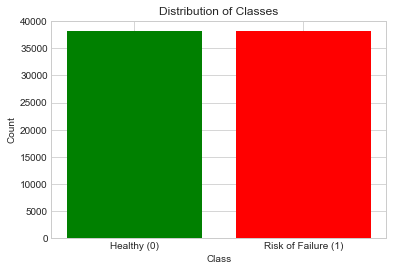

In [42]:
# Display new class count - with synthethic data
class_distribution(synthethic_data)

In [43]:
# Splitting intro train and test data
Xsynth_train, Xsynth_test, ysynth_train, ysynth_test = train_test_split(synthethic_data.drop(columns=['label']), 
                                                                        synthethic_data['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=123)

<hr style="border:1px solid black"> </hr>

## Modeling

In [44]:
# Instantiating logistic regression, decision tree, random forest, and xgboost models
logreg = LogisticRegression(random_state=123) # Logistic Regression 
dtc = DecisionTreeClassifier(random_state=123) # Decision Tree
rfc = RandomForestClassifier(random_state=123) # Random Forest
xgb = XGBClassifier(objective='binary:logistic', n_estimators=100) # XGBoost

In [45]:
# Neural Network
def neural_network():
    neural_network = Sequential([
        Dense(14, input_dim=13, activation='relu', name="Input_Layer"),
        Dense(8, activation='relu', name="Hidden_Layer_1"),
        Dense(1, activation='softmax', name="Output_Layer"),
    ], name="neural_network")

    neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return neural_network

print(neural_network().summary())

Model: "neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 14)                196       
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 8)                 120       
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 9         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________
None


### Part I - Imbalance vs Balance

#### Data Imbalance

In [46]:
# Logistic Regression
logregfit = logreg.fit(X_train, y_train)
logpred = logregfit.predict(X_test)

# Scores
accuracy_logreg = accuracy_score(y_test, logpred)
f1_logreg = f1_score(y_test, logpred)
recall_logreg = recall_score(y_test, logpred)
prec_logreg = precision_score(y_test, logpred)

In [47]:
# Decision Tree
dtcfit = dtc.fit(X_train, y_train)
dtcpred = dtcfit.predict(X_test)

# Score
accuracy_dtc = accuracy_score(y_test, dtcpred)
f1_dtc = f1_score(y_test, dtcpred)
recall_dtc = recall_score(y_test, dtcpred)
prec_dtc = precision_score(y_test, dtcpred)

In [48]:
# Random Forest
rfcfit = rfc.fit(X_train, y_train)
rfcpred = rfcfit.predict(X_test)

# Score
accuracy_rfc = accuracy_score(y_test, rfcpred)
f1_rfc = f1_score(y_test, rfcpred)
recall_rfc = recall_score(y_test, rfcpred)
prec_rfc = precision_score(y_test, rfcpred)

In [49]:
# XGBoost
xgbfit = xgb.fit(X_train, y_train)
xgbpred = xgbfit.predict(X_test)

# Score
accuracy_xgb = accuracy_score(y_test, xgbpred)
f1_xgb = f1_score(y_test, xgbpred)
recall_xgb = recall_score(y_test, xgbpred)
prec_xgb = precision_score(y_test, xgbpred)

[20:42:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
# Neural Network
nn = neural_network()
nn.fit(X_train, y_train, epochs = 30)
nn_pred = nn.predict(X_test)

# Score
accuracy_nn = accuracy_score(y_test, nn_pred)
f1_nn = f1_score(y_test, nn_pred)
recall_nn = recall_score(y_test, nn_pred)
prec_nn = precision_score(y_test, nn_pred)

Epoch 1/30
1033/1033 [==============================] - 2s 1ms/step - loss: 0.3558 - accuracy: 0.0783
Epoch 2/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1891 - accuracy: 0.0777
Epoch 3/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1812 - accuracy: 0.0785
Epoch 4/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1756 - accuracy: 0.0768
Epoch 5/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1801 - accuracy: 0.0782
Epoch 6/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1771 - accuracy: 0.0788
Epoch 7/30
1033/1033 [==============================] - 2s 2ms/step - loss: 0.1762 - accuracy: 0.0795
Epoch 8/30
1033/1033 [==============================] - 1s 1ms/step - loss: 0.1718 - accuracy: 0.0764
Epoch 9/30
1033/1033 [==============================] - 1s 1ms/step - loss: 0.1736 - accuracy: 0.0783
Epoch 10/30
1033/1033 [==============================] - 1s 1ms/step - loss: 0.176

#### Dealing with Data Imbalance

- Upsampling:

In [51]:
# Logistic Regression
logregbal = logreg.fit(Xbal_train, ybal_train)
logbalpred = logregbal.predict(Xbal_test)

# Scores
accuracy_logregbal = accuracy_score(ybal_test, logbalpred)
f1_logregbal = f1_score(ybal_test, logbalpred)
recall_logregbal = recall_score(ybal_test, logbalpred)
prec_logregbal = precision_score(ybal_test, logbalpred)

In [52]:
# Decision Tree 
dtcbal = dtc.fit(Xbal_train, ybal_train)
dtcbalpred = dtcbal.predict(Xbal_test)

# Scores
accuracy_dtcbal = accuracy_score(ybal_test, dtcbalpred)
f1_dtcbal = f1_score(ybal_test, dtcbalpred)
recall_dtcbal = recall_score(ybal_test, dtcbalpred)
prec_dtcbal = precision_score(ybal_test, dtcbalpred)

In [53]:
# Random Forest
rfcbal = rfc.fit(Xbal_train, ybal_train)
rfcbalpred = rfcbal.predict(Xbal_test)

# Scores
accuracy_rfcbal = accuracy_score(ybal_test, rfcbalpred)
f1_rfcbal = f1_score(ybal_test, rfcbalpred)
recall_rfcbal = recall_score(ybal_test, rfcbalpred)
prec_rfcbal = precision_score(ybal_test, rfcbalpred)

In [54]:
# XGBoost
xgbbal = xgb.fit(Xbal_train, ybal_train)
xgbbalpred = xgbbal.predict(Xbal_test)

# Scores
accuracy_xgbbal = accuracy_score(ybal_test, xgbbalpred)
f1_xgbbal = f1_score(ybal_test, xgbbalpred)
recall_xgbbal = recall_score(ybal_test, xgbbalpred)
prec_xgbbal = precision_score(ybal_test, xgbbalpred)

[20:43:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
# Neural Network
nn_bal = neural_network()
nn_bal.fit(Xbal_train, ybal_train, epochs = 30)
nnbal_pred = nn_bal.predict(Xbal_test)

# Scores
accuracy_nnbal = accuracy_score(ybal_test, nnbal_pred)
f1_nnbal = f1_score(ybal_test, nnbal_pred)
recall_nnbal = recall_score(ybal_test, nnbal_pred)
prec_nnbal = precision_score(ybal_test, nnbal_pred)

Epoch 1/30
1906/1906 [==============================] - 3s 1ms/step - loss: 0.4947 - accuracy: 0.5007
Epoch 2/30
1906/1906 [==============================] - 4s 2ms/step - loss: 0.4614 - accuracy: 0.5016
Epoch 3/30
1906/1906 [==============================] - 3s 1ms/step - loss: 0.4582 - accuracy: 0.5003
Epoch 4/30
1906/1906 [==============================] - 3s 1ms/step - loss: 0.4498 - accuracy: 0.5014
Epoch 5/30
1906/1906 [==============================] - 4s 2ms/step - loss: 0.4471 - accuracy: 0.5001
Epoch 6/30
1906/1906 [==============================] - 4s 2ms/step - loss: 0.4463 - accuracy: 0.4960
Epoch 7/30
1906/1906 [==============================] - 3s 1ms/step - loss: 0.4438 - accuracy: 0.5016
Epoch 8/30
1906/1906 [==============================] - 3s 1ms/step - loss: 0.4465 - accuracy: 0.5025
Epoch 9/30
1906/1906 [==============================] - 3s 2ms/step - loss: 0.4456 - accuracy: 0.5026
Epoch 10/30
1906/1906 [==============================] - 3s 2ms/step - loss: 0.443

- Synthethic Data:

In [56]:
# Logistic Regression
logregsynth = logreg.fit(Xsynth_train, ysynth_train)
logsynthpred = logregsynth.predict(Xsynth_test)

# Scores
accuracy_logregsynth = accuracy_score(ysynth_test, logsynthpred)
f1_logregsynth = f1_score(ysynth_test, logsynthpred)
recall_logregsynth = recall_score(ysynth_test, logsynthpred)
prec_logregsynth = precision_score(ysynth_test, logsynthpred)

In [57]:
# Decision Tree
dtcsynth = dtc.fit(Xsynth_train, ysynth_train)
dtcsynthpred = dtcsynth.predict(Xsynth_test)

# Scores
accuracy_dtcsynth = accuracy_score(ysynth_test, dtcsynthpred)
f1_dtcsynth = f1_score(ysynth_test, dtcsynthpred)
recall_dtcsynth = recall_score(ysynth_test, dtcsynthpred)
prec_dtcsynth = precision_score(ysynth_test, dtcsynthpred)

In [58]:
# Random Forest
rfcsynth = rfc.fit(Xsynth_train, ysynth_train)
rfcsynthpred = rfcsynth.predict(Xsynth_test)

# Scores
accuracy_rfcsynth = accuracy_score(ysynth_test, rfcsynthpred)
f1_rfcsynth = f1_score(ysynth_test, rfcsynthpred)
recall_rfcsynth = recall_score(ysynth_test, rfcsynthpred)
prec_rfcsynth = precision_score(ysynth_test, rfcsynthpred)

In [59]:
# XGBoost
xgbsynth = xgb.fit(Xsynth_train, ysynth_train)
xgbsynthpred = xgbsynth.predict(Xsynth_test)

# Scores
accuracy_xgbsynth = accuracy_score(ysynth_test, xgbsynthpred)
f1_xgbsynth = f1_score(ysynth_test, xgbsynthpred)
recall_xgbsynth = recall_score(ysynth_test, xgbsynthpred)
prec_xgbsynth = precision_score(ysynth_test, xgbsynthpred)

[20:45:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
# Neural Network
nn_synth = neural_network()
nn_synth.fit(Xsynth_train, ysynth_train, epochs = 30)
nnsynth_pred = nn_bal.predict(Xsynth_test)

# Scores
accuracy_nnsynth = accuracy_score(ysynth_test, nnsynth_pred)
f1_nnsynth = f1_score(ysynth_test, nnsynth_pred)
recall_nnsynth = recall_score(ysynth_test, nnsynth_pred)
prec_nnsynth = precision_score(ysynth_test, nnsynth_pred)

Epoch 1/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.2914 - accuracy: 0.4998
Epoch 2/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.1196 - accuracy: 0.5022
Epoch 3/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.1112 - accuracy: 0.5037
Epoch 4/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.1052 - accuracy: 0.4978
Epoch 5/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1047 - accuracy: 0.4990: 0s - loss: 0.1047 - accuracy: 0.
Epoch 6/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.1010 - accuracy: 0.5036
Epoch 7/30
1907/1907 [==============================] - 5s 2ms/step - loss: 0.1004 - accuracy: 0.5001
Epoch 8/30
1907/1907 [==============================] - 3s 1ms/step - loss: 0.1016 - accuracy: 0.5047
Epoch 9/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.0988 - accuracy: 0.4986
Epoch 10/30
1907/1907 [=========================

### Finding Best Model

- Inspecting Scores:

In [61]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network',
          'Logistic Regression with Balanced Data', 'Decision Tree with Balanced Data', 
          'Random Forest with Balanced Data', 'XGBoost with Balanced Data', 
          'Neural Network with Balanced Data', 'Logistic Regression with Synthethic Data', 
          'Decision Tree with Synthethic Data', 'Random Forest with Synthethic Data', 
          'XGBoost with Synthethic Data', 'Neural Network with Synthethic Data']
accuracies = np.array([accuracy_logreg, accuracy_dtc, accuracy_rfc, accuracy_xgb, accuracy_nn,
                       accuracy_logregbal, accuracy_dtcbal, accuracy_rfcbal, accuracy_xgbbal, accuracy_nnbal,
                       accuracy_logregsynth, accuracy_dtcsynth, accuracy_rfcsynth, accuracy_xgbsynth, accuracy_nnsynth
                      ])
recalls = np.array([recall_logreg, recall_dtc, recall_rfc, recall_xgb, recall_nn,
                    recall_logregbal, recall_dtcbal, recall_rfcbal, recall_xgbbal, recall_nnbal,
                    recall_logregsynth, recall_dtcsynth, recall_rfcsynth, recall_xgbsynth, recall_nnsynth
                   ]) 
precisions = np.array([prec_logreg, prec_dtc, prec_rfc, prec_xgb, prec_nn,
                       prec_logregbal, prec_dtcbal, prec_rfcbal, prec_xgbbal, prec_nnbal,
                       prec_logregsynth, prec_dtcsynth, prec_rfcsynth, prec_xgbsynth, prec_nnsynth
                      ]) 
f1_score = np.array([f1_logreg, f1_dtc, f1_rfc, f1_xgb, f1_nn,
                     f1_logregbal, f1_dtcbal, f1_rfcbal, f1_xgbbal, f1_nnbal,
                     f1_logregsynth, f1_dtcsynth, f1_rfcsynth, f1_xgbsynth, f1_nnsynth
                      ])


In [62]:
# Creating DataFrame with Scores
scores = {'Accuracy': accuracies,
          'Recall': recalls,
          'Precision' : precisions,
          'F1_Score': f1_score
         }

scores_df = pd.DataFrame(scores, 
                         columns = ['Accuracy', 'Recall', 'Precision', 'F1_Score'], 
                         index = models)


In [65]:
inspect = ['Decision Tree with Balanced Data', 'Random Forest with Balanced Data', 'XGBoost with Balanced Data',
           'Logistic Regression with Synthethic Data', 'Decision Tree with Synthethic Data', 
           'Random Forest with Synthethic Data', 'XGBoost with Synthethic Data']

scores_df.style.apply(lambda x: ['background: lightyellow' 
                                 if x.name in inspect 
                                 else ''
                                 for i in x], axis=1)

,Accuracy,Recall,Precision,F1_Score
Logistic Regression,0.951476,0.403624,0.862676,0.549944
Decision Tree,0.906704,0.420099,0.378338,0.398126
Random Forest,0.952081,0.428336,0.841424,0.567686
XGBoost,0.950145,0.416804,0.813505,0.551198
Neural Network,0.073451,1.000000,0.073451,0.136850
Logistic Regression with Balanced Data,0.764150,0.701579,0.800601,0.747826
Decision Tree with Balanced Data,0.967797,0.999474,0.939750,0.968692
Random Forest with Balanced Data,0.993113,0.999474,0.986878,0.993136
XGBoost with Balanced Data,0.922870,0.909605,0.933937,0.921610
Neural Network with Balanced Data,0.498459,1.000000,0.498459,0.665295


- Inspecting False Negatives and False Positives:

In [66]:
# Extracting Number of FNs and FPS
_, fp_dtcbal, fn_dtcbal, _ = confusion_matrix(ybal_test, dtcbalpred).ravel()
_, fp_rfcbal, fn_rfcbal, _ = confusion_matrix(ybal_test, rfcbalpred).ravel()
_, fp_xgbbal, fn_xgbbal, _ = confusion_matrix(ybal_test, xgbbalpred).ravel()

_, fp_logregsynth, fn_logregsynth, _ = confusion_matrix(ysynth_test, logsynthpred).ravel()
_, fp_dtcsynth, fn_dtcsynth, _ = confusion_matrix(ysynth_test, dtcsynthpred).ravel()
_, fp_rfcsynth, fn_rfcsynth, _ = confusion_matrix(ysynth_test, rfcsynthpred).ravel()
_, fp_xgbsynth, fn_xgbsynth, _ = confusion_matrix(ysynth_test, xgbsynthpred).ravel()

In [67]:
models_falses = ['Decision Tree with Balanced Data', 'Random Forest with Balanced Data', 'XGBoost with Balanced Data',
                 'Logistic Regression with Synthethic Data', 'Decision Tree with Synthethic Data',
                 'Random Forest with Synthethic Data','XGBoost with Synthethic Data', ]
fpositives = np.array([fp_dtcbal, fp_rfcbal, fp_xgbbal, fp_logregsynth, fp_dtcsynth, fp_rfcsynth, fp_xgbsynth])
fnegatives = np.array([fn_dtcbal, fn_rfcbal, fn_xgbbal, fn_logregsynth, fn_dtcsynth, fn_rfcsynth, fn_xgbsynth]) 

In [68]:
# Creating DataFrame with False Positives and False Negatives
falses = {'False Positives': fpositives,
          'False Negatives': fnegatives,
         }

falses_df = pd.DataFrame(falses, 
                         columns = ['False Positives', 'False Negatives'], 
                         index = models_falses)

In [69]:
best = ['Random Forest with Balanced Data']

falses_df.style.apply(lambda x: ['background: lightgreen' 
                                 if x.name in best 
                                 else ''
                                 for i in x], axis=1)

,False Positives,False Negatives
Decision Tree with Balanced Data,487,4
Random Forest with Balanced Data,101,4
XGBoost with Balanced Data,489,687
Logistic Regression with Synthethic Data,694,852
Decision Tree with Synthethic Data,423,343
Random Forest with Synthethic Data,56,340
XGBoost with Synthethic Data,64,341


### Part II - Improving Best Model

- Stacking Models:

In [70]:
# Defining base models
base_models = [('dtc', DecisionTreeClassifier(random_state=123)),
               ('rfc', RandomForestClassifier(random_state=123)),
              ]
    
# define the stacking ensemble
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(random_state=123), cv=5)

In [71]:
# Fitting and Making Predictions
stack_fit = stack_model.fit(Xbal_train, ybal_train)
stack_pred = stack_fit.predict(Xbal_test)

In [81]:
# Scores
accuracy_stack = accuracy_score(ybal_test, stack_pred)
f1_stack = f1_score(ybal_test.to_numpy(), stack_pred)
recall_stack = recall_score(ybal_test, stack_pred)
prec_stack = precision_score(ybal_test, stack_pred)
_, fp_stack, fn_stack, _ = confusion_matrix(ybal_test, stack_pred).ravel()

In [82]:
pd.DataFrame([[accuracy_stack, f1_stack, recall_stack, prec_stack, fp_stack, fn_stack]], 
             columns = ['Accuracy', 'F1_Score', 'Recall', 'Precision', 'False_Positives', 'False_Negatives'],
             index = ['Stacking Model - Logistic Estimator'])

,Accuracy,F1_Score,Recall,Precision,False_Positives,False_Negatives
Stacking Model - Logistic Estimator,0.997114,0.997112,0.999474,0.994762,40,4


- Grid Search:

In [87]:
# Creating Param Dictionary
params = {"final_estimator": [LogisticRegression(random_state=123), 
                              DecisionTreeClassifier(random_state=123), 
                              RandomForestClassifier(random_state=123),
                              XGBClassifier(objective='binary:logistic', n_estimators=100)
                             ]
         }

In [90]:
# Instantiating Grid Search
stack_grid = GridSearchCV(estimator = stack_model, 
                          param_grid = params, 
                          cv = 5,
                          scoring = "f1",
                          verbose = 3,
                          n_jobs = -1)

In [91]:
# Fitting and predicting with best model
best_fit = stack_grid.fit(Xbal_train, ybal_train)
best_pred = best_fit.predict(Xbal_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.0min finished


In [94]:
# Scores
accuracy_best = accuracy_score(ybal_test, best_pred)
f1_best = f1_score(ybal_test, stack_pred)
recall_best = recall_score(ybal_test, best_pred)
prec_best = precision_score(ybal_test, best_pred)
_, fp_best, fn_best, _ = confusion_matrix(ybal_test, best_pred).ravel()

In [101]:
pd.DataFrame([[accuracy_best, f1_best, recall_best, prec_best, fp_best, fn_best]], 
             columns = ['Accuracy', 'F1_Score', 'Recall', 'Precision', 'False_Positives', 'False_Negatives'],
             index = ['Stacking Model - Random Forest Estimator'])

,Accuracy,F1_Score,Recall,Precision,False_Positives,False_Negatives
Stacking Model - Random Forest Estimator,0.998426,0.997112,0.999342,0.997505,19,5
